# Retail Forecasting

## 1. Data Understanding and Preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('retail_data.csv')

In [4]:
df.shape

(1218, 12)

In [5]:
df.head()

,Product,date,Sales,Price Discount (%),In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
0,SKU1,2/5/2017,27750,0%,0,0,0,0.0,0,0,0,0
1,SKU1,2/12/2017,29023,0%,1,0,1,0.0,0,1,0,0
2,SKU1,2/19/2017,45630,17%,0,0,0,0.0,0,0,0,0
3,SKU1,2/26/2017,26789,0%,1,0,1,0.0,0,0,0,0
4,SKU1,3/5/2017,41999,17%,0,0,0,0.0,0,0,0,0


### i. check data types

In [6]:
df.dtypes

Product                object
date                   object
Sales                   int64
Price Discount (%)     object
In-Store Promo          int64
Catalogue Promo         int64
Store End Promo         int64
Google_Mobility       float64
Covid_Flag              int64
V_DAY                   int64
EASTER                  int64
CHRISTMAS               int64
dtype: object

In [7]:
df['date'] = pd.to_datetime(df['date'])

In [8]:
df.dtypes

Product                       object
date                  datetime64[ns]
Sales                          int64
Price Discount (%)            object
In-Store Promo                 int64
Catalogue Promo                int64
Store End Promo                int64
Google_Mobility              float64
Covid_Flag                     int64
V_DAY                          int64
EASTER                         int64
CHRISTMAS                      int64
dtype: object

In [9]:
df['Price Discount (%)'] = [x.replace('%', '') for x in df['Price Discount (%)']]
df['Price Discount (%)'] = df['Price Discount (%)'].astype(int)

In [10]:
df.dtypes

Product                       object
date                  datetime64[ns]
Sales                          int64
Price Discount (%)             int32
In-Store Promo                 int64
Catalogue Promo                int64
Store End Promo                int64
Google_Mobility              float64
Covid_Flag                     int64
V_DAY                          int64
EASTER                         int64
CHRISTMAS                      int64
dtype: object

All data types are correct

### ii. check missing values

In [11]:
df.apply(lambda x: sum(x.isnull()),axis=0)

Product               0
date                  0
Sales                 0
Price Discount (%)    0
In-Store Promo        0
Catalogue Promo       0
Store End Promo       0
Google_Mobility       0
Covid_Flag            0
V_DAY                 0
EASTER                0
CHRISTMAS             0
dtype: int64

No missing values were found

### iii. Outliers

<AxesSubplot:xlabel='Sales', ylabel='Product'>

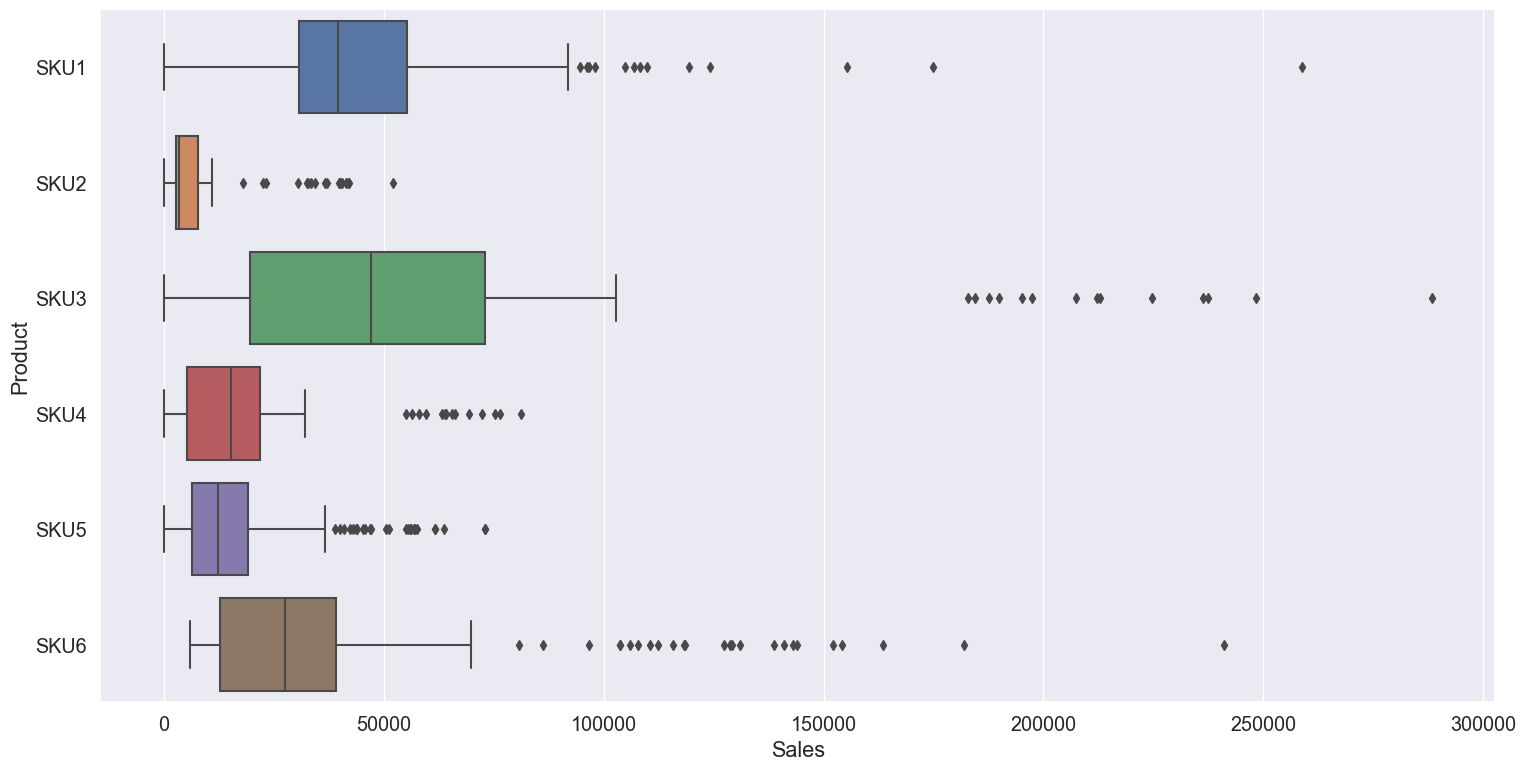

In [12]:
plt.figure(figsize=(18,9))
sns.set(font_scale = 1.3)
sns.boxplot(data = df, y = 'Product', x = "Sales", dodge=False)

According to the graphs, there are products with `Sales` equals to zero. It is believed that the testing data is mixed into the data set after checking the data.

In [14]:
# remove the 0 Sales
df = df.drop(df[df.Sales == 0].index)

<AxesSubplot:xlabel='Sales', ylabel='Product'>

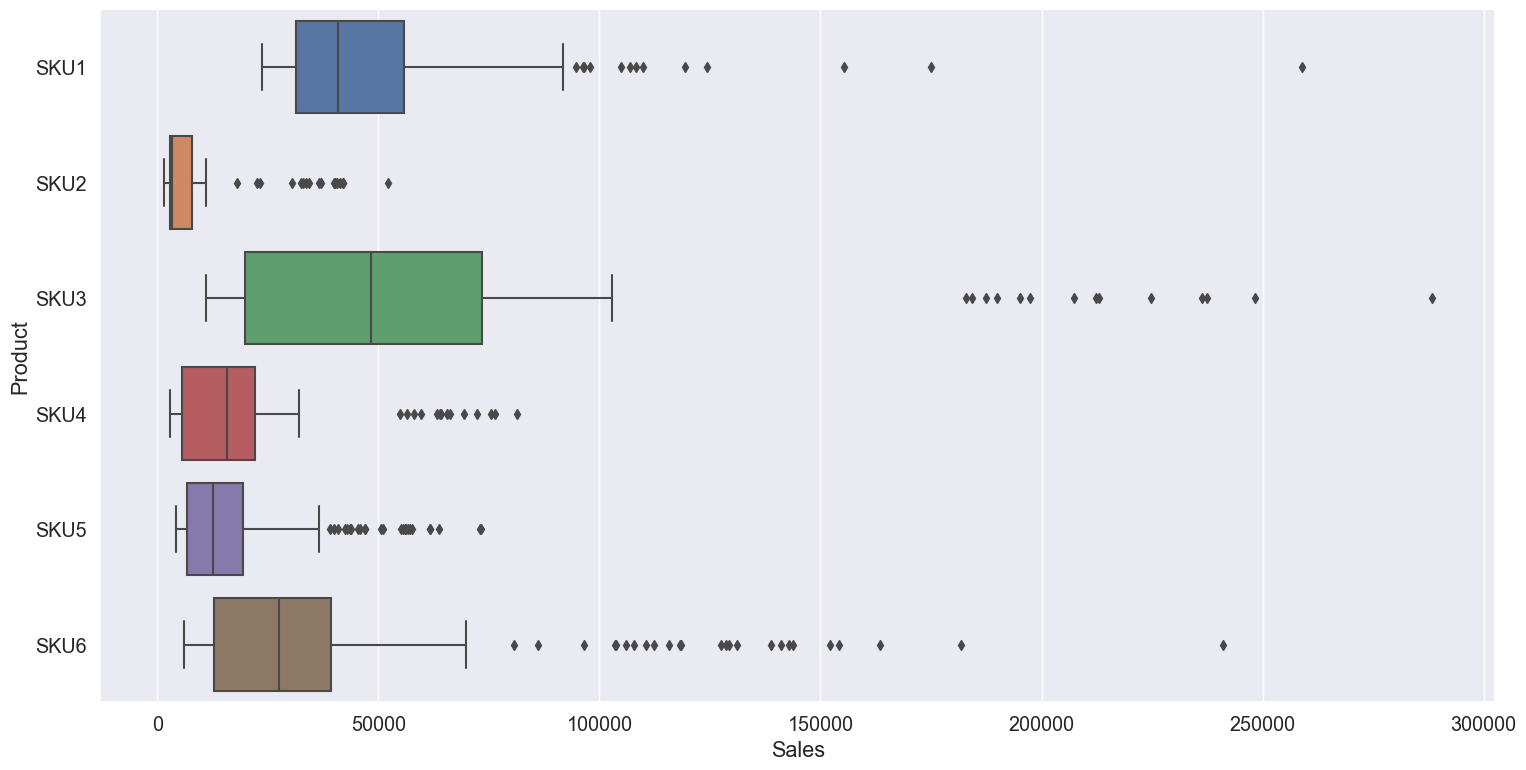

In [15]:
plt.figure(figsize=(18,9))
sns.set(font_scale = 1.3)
sns.boxplot(data = df, y = 'Product', x = "Sales", dodge=False)

After removing the `Sales` equal to zero, there are still some outliers in the `Sales` feature. But since we do not have enough information on the components for the sales, it is not appropriate to treat it as an outlier.

## 2. Exploratory Data Analysis

### i. describe the data

In [16]:
round(df.describe(datetime_is_numeric=True, include='all'),2)

,Product,date,Sales,Price Discount (%),In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
count,1188,1188,1188.00,1188.00,1188.00,1188.00,1188.00,1188.00,1188.00,1188.00,1188.00,1188.00
unique,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,SKU1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2018-12-26 12:00:00,31059.70,24.71,0.47,0.21,0.35,-2.28,0.21,0.02,0.02,0.02
min,NaN,2017-02-05 00:00:00,1453.00,0.00,0.00,0.00,0.00,-28.49,0.00,0.00,0.00,0.00
25%,NaN,2018-01-14 00:00:00,7695.25,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,NaN,2018-12-26 12:00:00,20547.00,25.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,NaN,2019-12-08 00:00:00,40978.00,40.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
max,NaN,2020-11-15 00:00:00,288322.00,83.00,1.00,1.00,1.00,3.90,1.00,1.00,1.00,1.00


### ii. data visualisation

In [17]:
df_time = df.set_index('date')

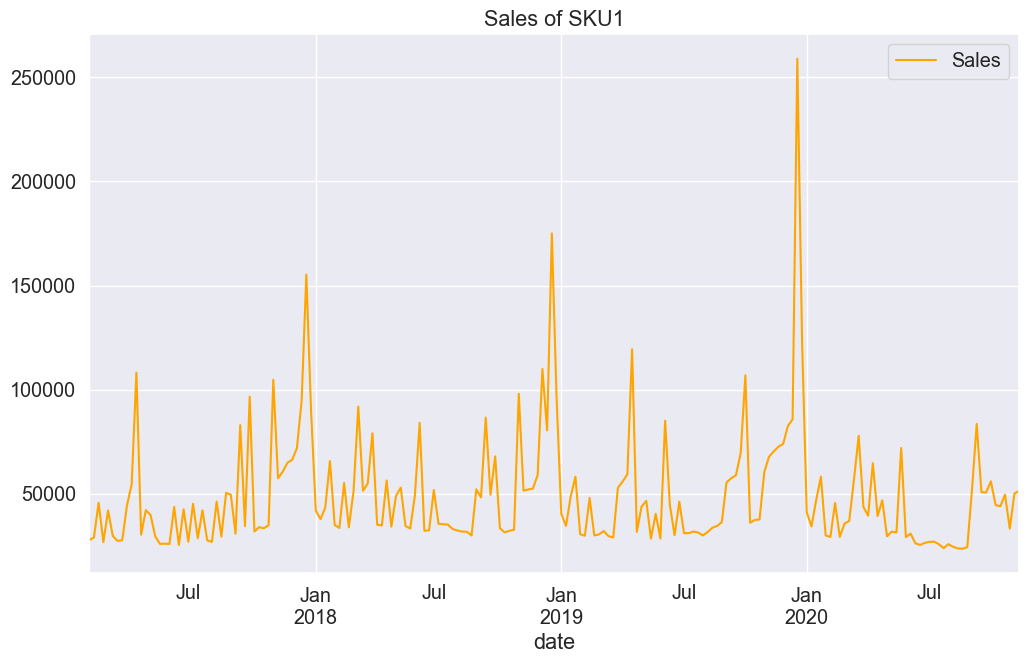

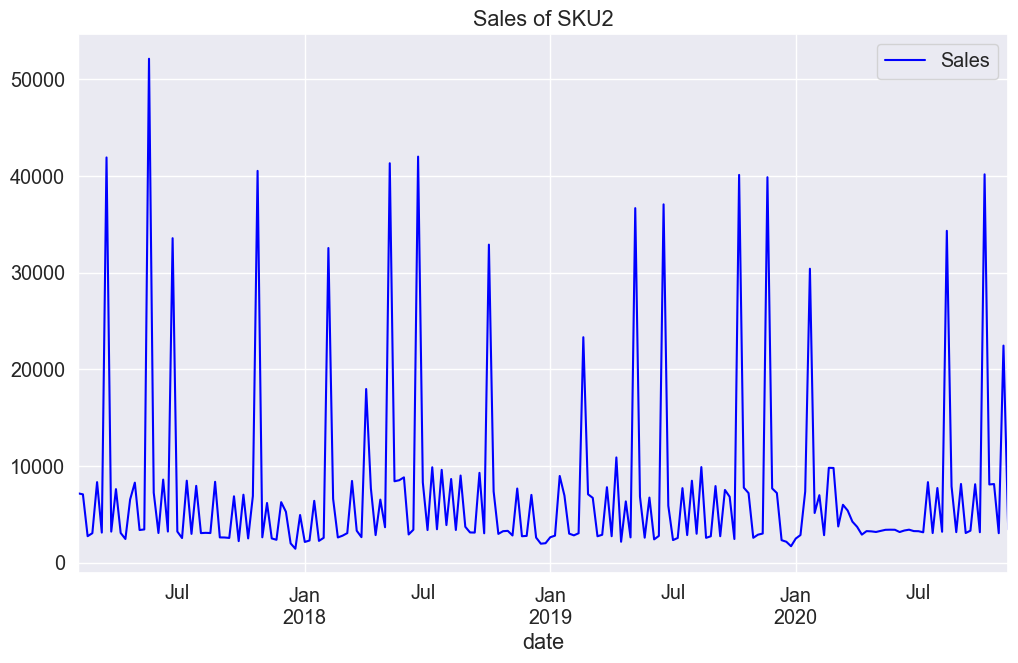

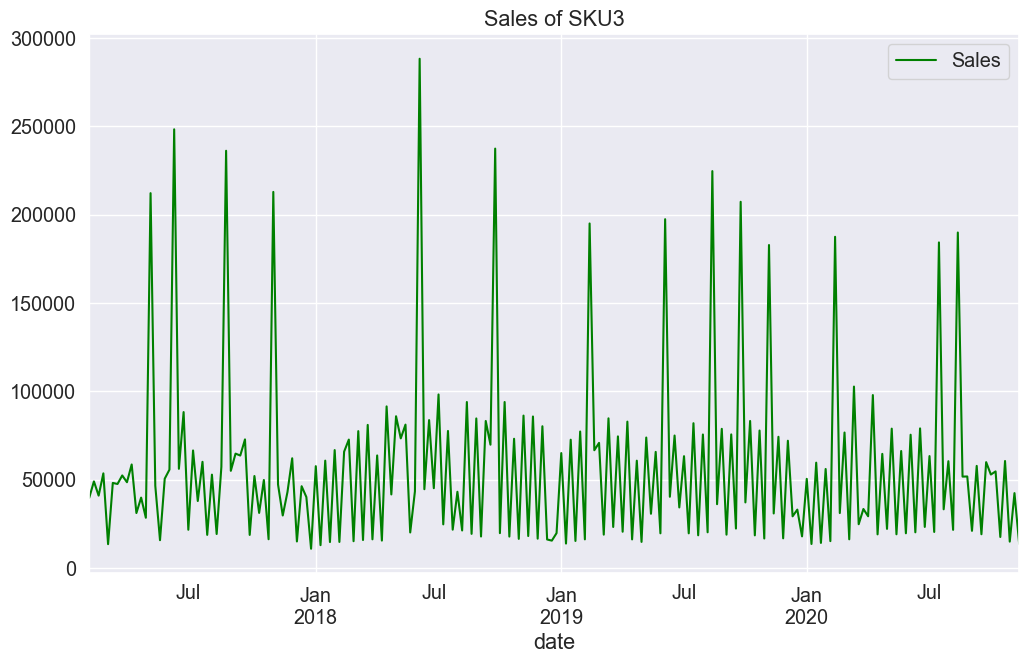

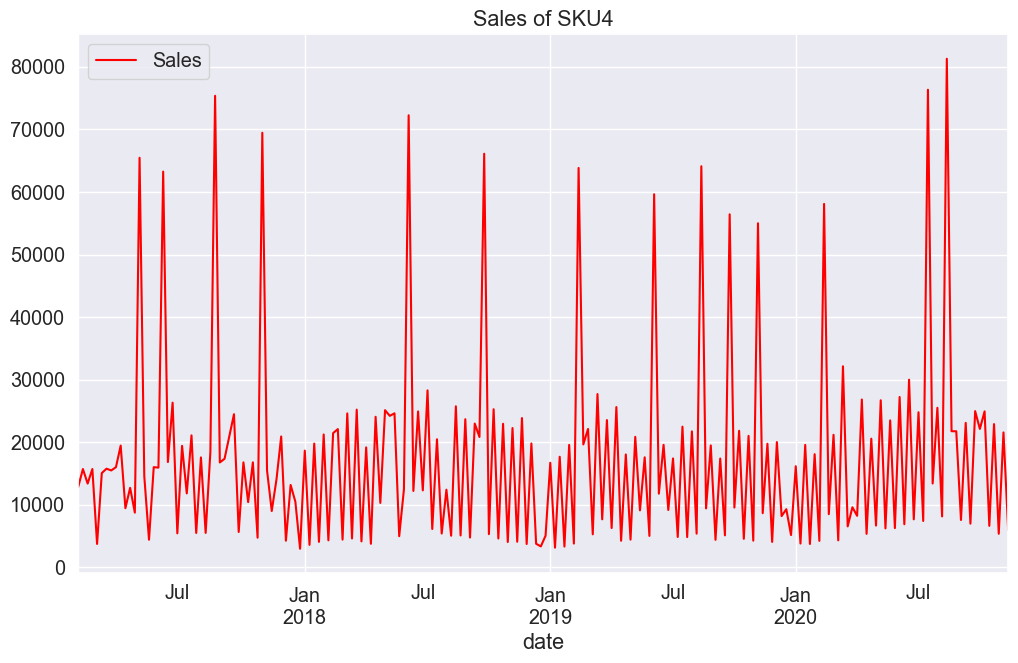

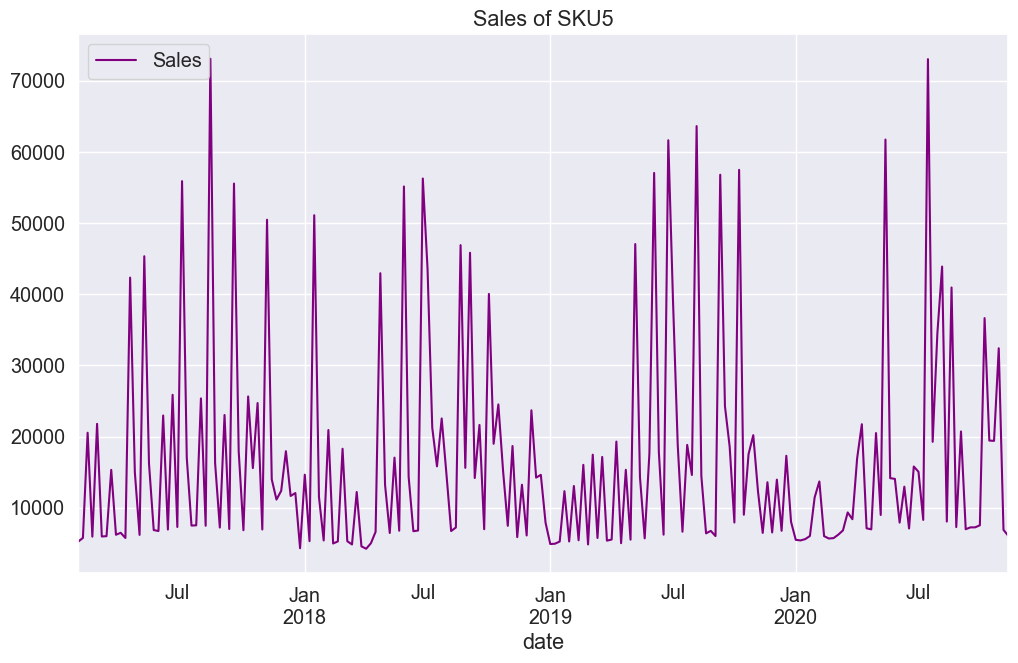

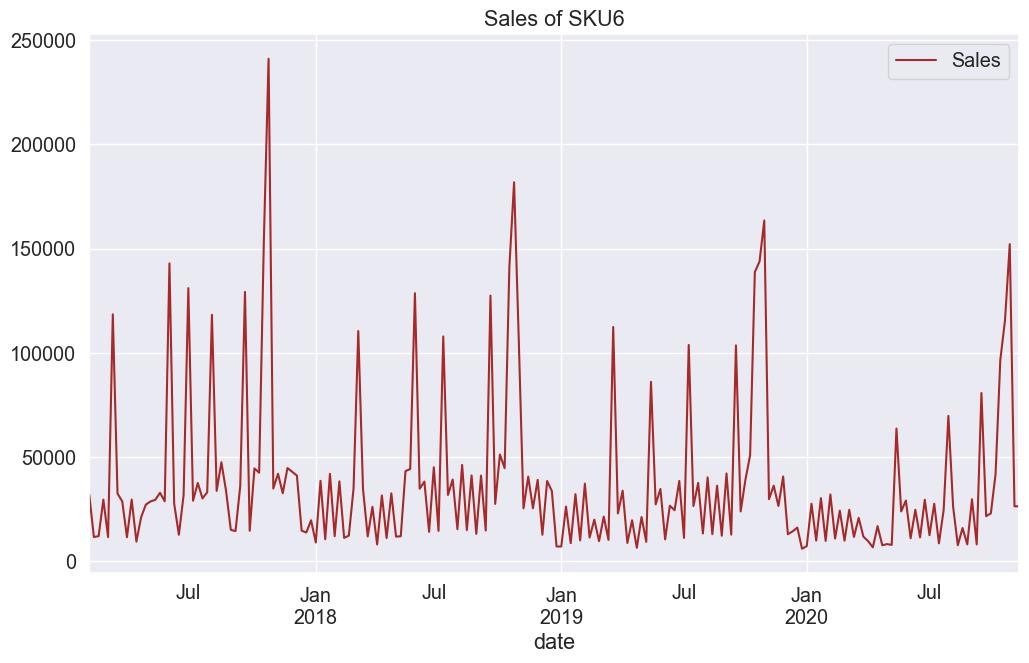

In [18]:
color=['orange', 'blue', 'green', 'red', 'purple', 'brown']

for i, c in zip(range(1, 7), color):
    product_name = 'SKU' + str(i)
    df_sku = df_time[df_time['Product'] == product_name]
    plt.figure(figsize = (12,7))
    
    df_sku['Sales'].plot(title = f'Sales of {product_name}', legend= True, color = c)
    

### iii. correlation

In [19]:
df.corr()

,Sales,Price Discount (%),In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
Sales,1.000000,0.432887,0.252071,-0.124398,0.234811,0.044885,-0.047748,-0.011653,-0.013495,-0.013893
Price Discount (%),0.432887,1.000000,0.225429,-0.091492,0.234464,-0.207491,0.265120,-0.042953,0.003640,-0.035163
In-Store Promo,0.252071,0.225429,1.000000,-0.488728,0.367410,0.060471,-0.038873,0.020951,0.020951,0.021550
Catalogue Promo,-0.124398,-0.091492,-0.488728,1.000000,0.124778,0.075202,-0.098381,-0.045466,-0.045466,0.036468
Store End Promo,0.234811,0.234464,0.367410,0.124778,1.000000,0.082501,-0.067667,0.019489,-0.068211,0.009620
Google_Mobility,0.044885,-0.207491,0.060471,0.075202,0.082501,1.000000,-0.764376,0.076392,-0.111869,0.048450
Covid_Flag,-0.047748,0.265120,-0.038873,-0.098381,-0.067667,-0.764376,1.000000,0.015213,0.015213,-0.063385
V_DAY,-0.011653,-0.042953,0.020951,-0.045466,0.019489,0.076392,0.015213,1.000000,-0.020619,-0.017810
EASTER,-0.013495,0.003640,0.020951,-0.045466,-0.068211,-0.111869,0.015213,-0.020619,1.000000,-0.017810
CHRISTMAS,-0.013893,-0.035163,0.021550,0.036468,0.009620,0.048450,-0.063385,-0.017810,-0.017810,1.000000
